In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

import sys
sys.path.append("/home/twhit/smc_object_detection/")
from utils.misc import select_cuda_device

device = select_cuda_device()

Selected device 0, which has 11004 MB available.


### Load in ground truth

In [2]:
images = torch.load('../data/images.pt')
true_counts = torch.load('../data/true_counts.pt')
true_locs = torch.load('../data/true_locs.pt')
true_fluxes = torch.load('../data/true_fluxes.pt')

num_counts = true_counts.max().item() + 1  # |{0,1,2,...,max_count}|

### Load in SMC results

In [3]:
num_batches = 100
batch_size = 10
prior_max_objects = 10
num_catalogs_per_count = 500
num_catalogs = num_catalogs_per_count * (prior_max_objects + 1)

smcmh_runtime = torch.zeros([num_batches, batch_size])
smcmh_num_iters = torch.zeros([num_batches, batch_size])
smcmh_counts = torch.zeros([num_batches, batch_size, num_catalogs])
smcmh_locs = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects+1, 2])
smcmh_fluxes = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects+1])

smcmala_runtime = torch.zeros([num_batches, batch_size])
smcmala_num_iters = torch.zeros([num_batches, batch_size])
smcmala_counts = torch.zeros([num_batches, batch_size, num_catalogs])
smcmala_locs = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects, 2])
smcmala_fluxes = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects])

for b in range(num_batches):
    smcmh_counts[b] = torch.load(f'smc_mh/counts_{b}.pt')
    smcmh_locs[b] = torch.load(f'smc_mh/locs_{b}.pt')
    smcmh_fluxes[b] = torch.load(f'smc_mh/fluxes_{b}.pt')
    smcmh_runtime[b] = torch.load(f'smc_mh/runtime_{b}.pt')
    smcmh_num_iters[b] = torch.load(f'smc_mh/num_iters_{b}.pt')
    
    smcmala_counts[b] = torch.load(f'smc_mala/counts_{b}.pt')
    smcmala_locs[b] = torch.load(f'smc_mala/locs_{b}.pt')
    smcmala_fluxes[b] = torch.load(f'smc_mala/fluxes_{b}.pt')
    smcmala_runtime[b] = torch.load(f'smc_mala/runtime_{b}.pt')
    smcmala_num_iters[b] = torch.load(f'smc_mala/num_iters_{b}.pt')

smcmh_counts = smcmh_counts.flatten(0,1)
smcmh_locs = smcmh_locs.flatten(0,1)
smcmh_fluxes = smcmh_fluxes.flatten(0,1)
smcmh_runtime = smcmh_runtime.flatten(0,1)
smcmh_num_iters = smcmh_num_iters.flatten(0,1)

smcmala_counts = smcmala_counts.flatten(0,1)
smcmala_locs = smcmala_locs.flatten(0,1)
smcmala_fluxes = smcmala_fluxes.flatten(0,1)
smcmala_runtime = smcmala_runtime.flatten(0,1)
smcmala_num_iters = smcmala_num_iters.flatten(0,1)

### Load in SEP results

In [4]:
sep_counts = torch.load('sep/counts.pt')
sep_locs = torch.load('sep/locs.pt')
sep_fluxes = torch.load('sep/fluxes.pt')
sep_runtime = torch.load('sep/runtime.pt')

### Plot attributes

In [5]:
smcmh_color = "darkblue"
smcmh_marker = 'o'
sep_color = "darkred"
sep_marker = 's'
smcmala_color = "forestgreen"
smcmala_marker = 'v'
fontsize = 16
cmap = 'gray'

---

### Summary statistics across all images

##### MAE, RMSE, and classification accuracy of number of stars

SMC with MH kernel:

In [6]:
print(f'mae = {(smcmh_counts.mode(-1).values - true_counts).abs().mean()}')
print(f'rmse = {((smcmh_counts.mode(-1).values - true_counts) ** 2).mean().sqrt()}')
print(f'accuracy = {(smcmh_counts.mode(-1).values == true_counts).float().mean() * 100}%')

mae = 0.5870000123977661
rmse = 0.9159694314002991
accuracy = 52.499996185302734%


SMC with MALA kernel:

In [7]:
print(f'mae = {(smcmala_counts.mode(-1).values - true_counts).abs().mean()}')
print(f'rmse = {((smcmala_counts.mode(-1).values - true_counts) ** 2).mean().sqrt()}')
print(f'accuracy = {(smcmala_counts.mode(-1).values == true_counts).float().mean() * 100}%')

mae = 0.7059999704360962
rmse = 1.0695793628692627
accuracy = 47.70000076293945%


Source Extractor (SEP):

In [8]:
print(f'mae = {(sep_counts - true_counts).abs().mean()}')
print(f'rmse = {((sep_counts - true_counts) ** 2).mean().sqrt()}')
print(f'accuracy = {(sep_counts == true_counts).float().mean() * 100}%')

mae = 1.4889999628067017
rmse = 2.0151922702789307
accuracy = 27.200000762939453%


##### MAE and RMSE of total flux

SMC with MH kernel:

In [9]:
print(f'mae = {(smcmh_fluxes.sum(-1).median(-1).values - true_fluxes.sum(-1)).abs().mean()}')
print(f'rmse = {((smcmh_fluxes.sum(-1).median(-1).values - true_fluxes.sum(-1)) ** 2).mean().sqrt()}')

mae = 321.7645568847656
rmse = 519.689453125


SMC with MALA kernel:

In [10]:
print(f'mae = {(smcmala_fluxes.sum(-1).median(-1).values - true_fluxes.sum(-1)).abs().mean()}')
print(f'rmse = {((smcmala_fluxes.sum(-1).median(-1).values - true_fluxes.sum(-1)) ** 2).mean().sqrt()}')

mae = 833.045654296875
rmse = 1588.4210205078125


Source Extractor (SEP):

In [11]:
print(f'mae = {(sep_fluxes.sum(-1) - true_fluxes.sum(-1)).abs().mean()}')
print(f'rmse = {((sep_fluxes.sum(-1) - true_fluxes.sum(-1)) ** 2).mean().sqrt()}')

mae = 642.4202880859375
rmse = 1694.9329833984375


##### Runtime in seconds

SMC with MH kernel:

In [12]:
print(f'mean = {smcmh_runtime.mean()}')
print(f'median = {smcmh_runtime.median()}')

mean = 10.548097610473633
median = 10.287182807922363


SMC with MALA kernel:

In [13]:
print(f'mean = {smcmala_runtime.mean()}')
print(f'median = {smcmala_runtime.median()}')

mean = 26.729095458984375
median = 24.33102035522461


SEP:

In [14]:
print(f'mean = {sep_runtime.mean()}')
print(f'median = {sep_runtime.median()}')

mean = 0.005273469258099794
median = 0.005692788865417242


##### Number of SMC sampler iterations

SMC with MH kernel:

In [15]:
print(f'mean = {smcmh_num_iters.mean()}')
print(f'median = {smcmh_num_iters.median()}')

mean = 14.746999740600586
median = 15.0


SMC with MALA kernel:

In [16]:
print(f'mean = {smcmala_num_iters.mean()}')
print(f'median = {smcmala_num_iters.median()}')

mean = 23.190000534057617
median = 22.0


##### Number of unique catalogs

SMC with MH kernel:

In [17]:
smcmh_num_unique = torch.zeros(images.shape[0], device = device)
for i in range(images.shape[0]):
    smcmh_num_unique[i] = smcmh_fluxes[i].to(device).unique(dim=0).shape[0]

smcmh_num_unique = smcmh_num_unique.to('cpu')

print(f'mean = {smcmh_num_unique.mean()}')
print(f'median = {smcmh_num_unique.median()}')

mean = 1021.760986328125
median = 1054.0


In [18]:
smcmala_num_unique = torch.zeros(images.shape[0], device = device)
for i in range(images.shape[0]):
    smcmala_num_unique[i] = smcmala_fluxes[i].to(device).unique(dim=0).shape[0]

smcmala_num_unique = smcmala_num_unique.to('cpu')

print(f'mean = {smcmala_num_unique.mean()}')
print(f'median = {smcmala_num_unique.median()}')

mean = 709.552001953125
median = 709.0


### Plots: Number of stars

In [19]:
smcmh_est_count_mean = torch.zeros(num_counts)
smcmh_est_count_q05 = torch.zeros(num_counts)
smcmh_est_count_q95 = torch.zeros(num_counts)
smcmala_est_count_mean = torch.zeros(num_counts)
smcmala_est_count_q05 = torch.zeros(num_counts)
smcmala_est_count_q95 = torch.zeros(num_counts)
sep_est_count_mean = torch.zeros(num_counts)
sep_est_count_q05 = torch.zeros(num_counts)
sep_est_count_q95 = torch.zeros(num_counts)

smcmh_count_mae = torch.zeros(num_counts)
smcmala_count_mae = torch.zeros(num_counts)
sep_count_mae = torch.zeros(num_counts)

smcmh_count_accuracy = torch.zeros(num_counts)
smcmala_count_accuracy = torch.zeros(num_counts)
sep_count_accuracy = torch.zeros(num_counts)

smcmh_runtime_mean = torch.zeros(num_counts)
smcmala_runtime_mean = torch.zeros(num_counts)
sep_runtime_mean = torch.zeros(num_counts)
smcmh_num_iters_mean = torch.zeros(num_counts)
smcmala_num_iters_mean = torch.zeros(num_counts)

for c in range(num_counts):
    smcmh_est_count_mean[c] = smcmh_counts[true_counts == c].mode(-1).values.mean()
    smcmh_est_count_q05[c] = smcmh_counts[true_counts == c].mode(-1).values.quantile(0.05)
    smcmh_est_count_q95[c] = smcmh_counts[true_counts == c].mode(-1).values.quantile(0.95)
    smcmala_est_count_mean[c] = smcmala_counts[true_counts == c].mode(-1).values.mean()
    smcmala_est_count_q05[c] = smcmala_counts[true_counts == c].mode(-1).values.quantile(0.05)
    smcmala_est_count_q95[c] = smcmala_counts[true_counts == c].mode(-1).values.quantile(0.95)
    sep_est_count_mean[c] = sep_counts[true_counts == c].mean()
    sep_est_count_q05[c] = sep_counts[true_counts == c].quantile(0.05)
    sep_est_count_q95[c] = sep_counts[true_counts == c].quantile(0.95)
    
    smcmh_count_mae[c] = (smcmh_counts.mode(-1).values - true_counts)[true_counts == c].abs().mean()
    smcmala_count_mae[c] = (smcmala_counts.mode(-1).values - true_counts)[true_counts == c].abs().mean()
    sep_count_mae[c] = (sep_counts - true_counts)[true_counts == c].abs().mean()
    
    smcmh_count_accuracy[c] = (smcmh_counts.mode(-1).values == true_counts).float()[true_counts == c].mean()
    smcmala_count_accuracy[c] = (smcmala_counts.mode(-1).values == true_counts).float()[true_counts == c].mean()
    sep_count_accuracy[c] = (sep_counts == true_counts).float()[true_counts == c].mean()
    
    smcmh_runtime_mean[c] = smcmh_runtime[true_counts == c].mean()
    smcmala_runtime_mean[c] = smcmala_runtime[true_counts == c].mean()
    sep_runtime_mean[c] = sep_runtime[true_counts == c].mean()
    smcmh_num_iters_mean[c] = smcmh_num_iters[true_counts == c].mean()
    smcmala_num_iters_mean[c] = smcmala_num_iters[true_counts == c].mean()

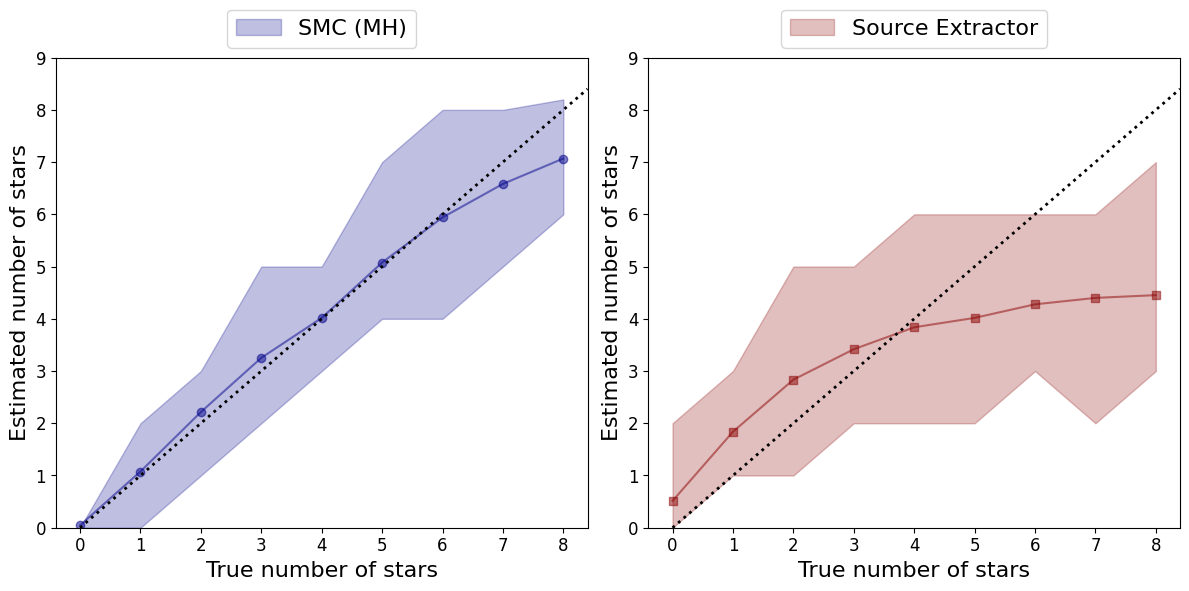

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))
_ = ax[0].plot(torch.arange(num_counts), smcmh_est_count_mean,
               color = smcmh_color, alpha = 0.5)
_ = ax[0].scatter(torch.arange(num_counts), smcmh_est_count_mean,
                  color = smcmh_color, marker = smcmh_marker, alpha = 0.5)
_ = ax[0].fill_between(x = torch.arange(num_counts),
                       y1 = smcmh_est_count_q05, y2 = smcmh_est_count_q95,
                       color = smcmh_color, alpha = 0.25, label = 'SMC (MH)')
_ = ax[0].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
_ = ax[0].legend(fancybox = True, loc = "upper center",
                 bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
_ = ax[0].set_xlabel('True number of stars', fontsize = fontsize)
_ = ax[0].set_ylabel('Estimated number of stars', fontsize = fontsize)
_ = ax[0].tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax[0].set_ylim((0,num_counts))

# _ = ax[1].plot(torch.arange(num_counts), smcmala_est_count_mean,
#                color = smcmala_color, alpha = 0.5)
# _ = ax[1].scatter(torch.arange(num_counts), smcmala_est_count_mean,
#                   color = smcmala_color, marker = smcmala_marker, alpha = 0.5)
# _ = ax[1].fill_between(x = torch.arange(num_counts),
#                        y1 = smcmala_est_count_q05, y2 = smcmala_est_count_q95,
#                        color = smcmala_color, alpha = 0.25, label = 'SMC (MALA)')
# _ = ax[1].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
# _ = ax[1].legend(fancybox = True, loc = "upper center",
#                  bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
# _ = ax[1].set_xlabel('True number of stars', fontsize = fontsize)
# _ = ax[1].set_ylabel('Estimated number of stars', fontsize = fontsize)
# _ = ax[1].tick_params(axis = "both", labelsize = 0.75 * fontsize)
# _ = ax[1].set_ylim((0,num_counts))

_ = ax[1].plot(torch.arange(num_counts), sep_est_count_mean,
               color = sep_color, alpha = 0.5)
_ = ax[1].scatter(torch.arange(num_counts), sep_est_count_mean,
                  color = sep_color, marker = sep_marker, alpha = 0.5)
_ = ax[1].fill_between(x = torch.arange(num_counts),
                       y1 = sep_est_count_q05, y2 = sep_est_count_q95,
                       color = sep_color, alpha = 0.25, label = 'Source Extractor')
_ = ax[1].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
_ = ax[1].legend(fancybox = True, loc = "upper center",
                 bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
_ = ax[1].set_xlabel('True number of stars', fontsize = fontsize)
_ = ax[1].set_ylabel('Estimated number of stars', fontsize = fontsize)
_ = ax[1].tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax[1].set_ylim((0,num_counts))

fig.tight_layout()

In [21]:
np.random.seed(1)

num_boot_samples = 10000

smcmh_mae_bounds = torch.zeros(num_counts, 2)
smcmala_mae_bounds = torch.zeros(num_counts, 2)
sep_mae_bounds = torch.zeros(num_counts, 2)

for c in range(num_counts):
    orig = (smcmh_counts.mode(-1).values - true_counts)[true_counts == c].abs()
    boot_mae = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_mae[j] = torch.tensor(boot_sample.mean())
    
    smcmh_mae_bounds[c] = boot_mae.quantile(torch.tensor((0.05, 0.95)))

for c in range(num_counts):
    orig = (smcmala_counts.mode(-1).values - true_counts)[true_counts == c].abs()
    boot_mae = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_mae[j] = torch.tensor(boot_sample.mean())
    
    smcmala_mae_bounds[c] = boot_mae.quantile(torch.tensor((0.05, 0.95)))
    
for c in range(num_counts):
    orig = (sep_counts - true_counts)[true_counts == c].abs()
    boot_mae = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_mae[j] = torch.tensor(boot_sample.mean())
    
    sep_mae_bounds[c] = boot_mae.quantile(torch.tensor((0.05, 0.95)))

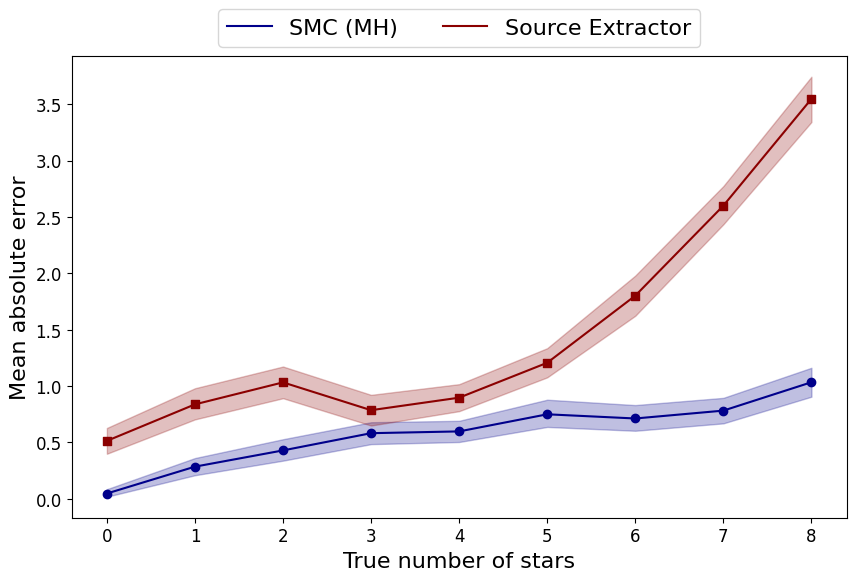

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.plot(torch.arange(num_counts), smcmh_count_mae,
            color = smcmh_color, label = 'SMC (MH)')
_ = ax.scatter(torch.arange(num_counts), smcmh_count_mae,
               color = smcmh_color, marker = smcmh_marker)
_ = ax.fill_between(x = torch.arange(num_counts),
                    y1 = smcmh_mae_bounds[:,0], y2 = smcmh_mae_bounds[:,1],
                    color = smcmh_color, alpha = 0.25)

# _ = ax.plot(torch.arange(num_counts), smcmala_count_mae,
#             color = smcmala_color, label = 'SMC (MALA)')
# _ = ax.scatter(torch.arange(num_counts), smcmala_count_mae,
#                color = smcmala_color, marker = smcmala_marker)
# _ = ax.fill_between(x = torch.arange(num_counts),
#                     y1 = smcmala_mae_bounds[:,0], y2 = smcmala_mae_bounds[:,1],
#                     color = smcmala_color, alpha = 0.25)

_ = ax.plot(torch.arange(num_counts), sep_count_mae,
            color = sep_color, label = 'Source Extractor')
_ = ax.scatter(torch.arange(num_counts), sep_count_mae,
               color = sep_color, marker = sep_marker)
_ = ax.fill_between(x = torch.arange(num_counts),
                    y1 = sep_mae_bounds[:,0], y2 = sep_mae_bounds[:,1],
                    color = sep_color, alpha = 0.25)

_ = ax.set_xlabel('True number of stars', fontsize = fontsize)
_ = ax.set_ylabel('Mean absolute error', fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax.legend(ncol = 3, fancybox = True, loc = "upper center",
              bbox_to_anchor = (0.5,1.125), fontsize = fontsize)

# fig.savefig('figures/divide_and_conquer_count_mae.png', dpi = 250, transparent = True)

In [23]:
np.random.seed(1)

num_boot_samples = 10000

smcmh_accuracy_bounds = torch.zeros(num_counts, 2)
smcmala_accuracy_bounds = torch.zeros(num_counts, 2)
sep_accuracy_bounds = torch.zeros(num_counts, 2)

for c in range(num_counts):
    orig = (smcmh_counts.mode(-1).values == true_counts).float()[true_counts == c]
    boot_accuracy = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_accuracy[j] = torch.tensor(boot_sample.mean())
    
    smcmh_accuracy_bounds[c] = boot_accuracy.quantile(torch.tensor((0.05, 0.95)))

for c in range(num_counts):
    orig = (smcmala_counts.mode(-1).values == true_counts).float()[true_counts == c]
    boot_accuracy = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_accuracy[j] = torch.tensor(boot_sample.mean())
    
    smcmala_accuracy_bounds[c] = boot_accuracy.quantile(torch.tensor((0.05, 0.95)))
    
for c in range(num_counts):
    orig = (sep_counts == true_counts).float()[true_counts == c]
    boot_accuracy = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_accuracy[j] = torch.tensor(boot_sample.mean())
    
    sep_accuracy_bounds[c] = boot_accuracy.quantile(torch.tensor((0.05, 0.95)))

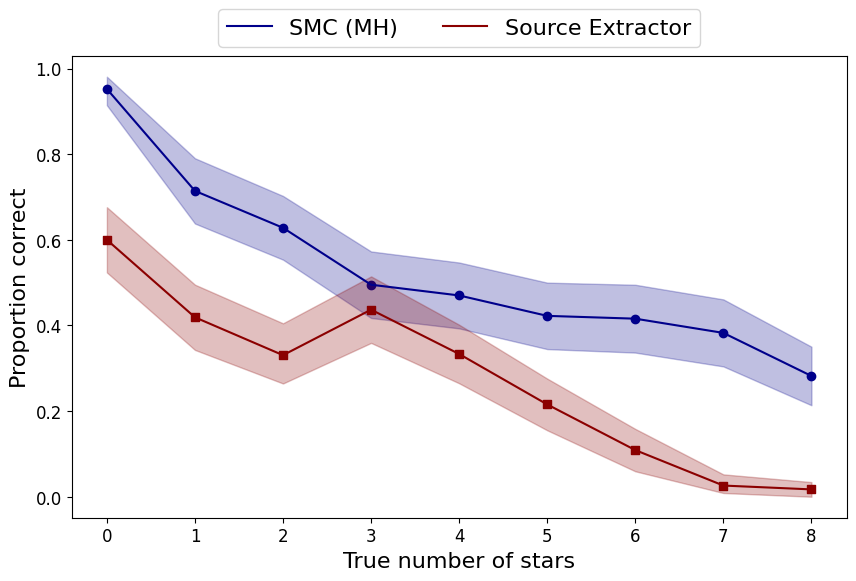

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.plot(torch.arange(num_counts), smcmh_count_accuracy,
            color = smcmh_color, label = 'SMC (MH)')
_ = ax.scatter(torch.arange(num_counts), smcmh_count_accuracy,
               color = smcmh_color, marker = smcmh_marker)
_ = ax.fill_between(x = torch.arange(num_counts),
                    y1 = smcmh_accuracy_bounds[:,0], y2 = smcmh_accuracy_bounds[:,1],
                    color = smcmh_color, alpha = 0.25)

# _ = ax.plot(torch.arange(num_counts), smcmala_count_accuracy,
#             color = smcmala_color, label = 'SMC (MALA)')
# _ = ax.scatter(torch.arange(num_counts), smcmala_count_accuracy,
#                color = smcmala_color, marker = smcmala_marker)
# _ = ax.fill_between(x = torch.arange(num_counts),
#                     y1 = smcmala_accuracy_bounds[:,0], y2 = smcmala_accuracy_bounds[:,1],
#                     color = smcmala_color, alpha = 0.25)

_ = ax.plot(torch.arange(num_counts), sep_count_accuracy,
            color = sep_color, label = 'Source Extractor')
_ = ax.scatter(torch.arange(num_counts), sep_count_accuracy,
               color = sep_color, marker = sep_marker)
_ = ax.fill_between(x = torch.arange(num_counts),
                    y1 = sep_accuracy_bounds[:,0], y2 = sep_accuracy_bounds[:,1],
                    color = sep_color, alpha = 0.25)

_ = ax.legend(ncol = 3, fancybox = True, loc = "upper center",
              bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
_ = ax.set_xlabel('True number of stars', fontsize = fontsize)
_ = ax.set_ylabel('Proportion correct', fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)

# fig.savefig('figures/divide_and_conquer_count_accuracy.png', dpi = 250, transparent = True)

### Plots: Total flux

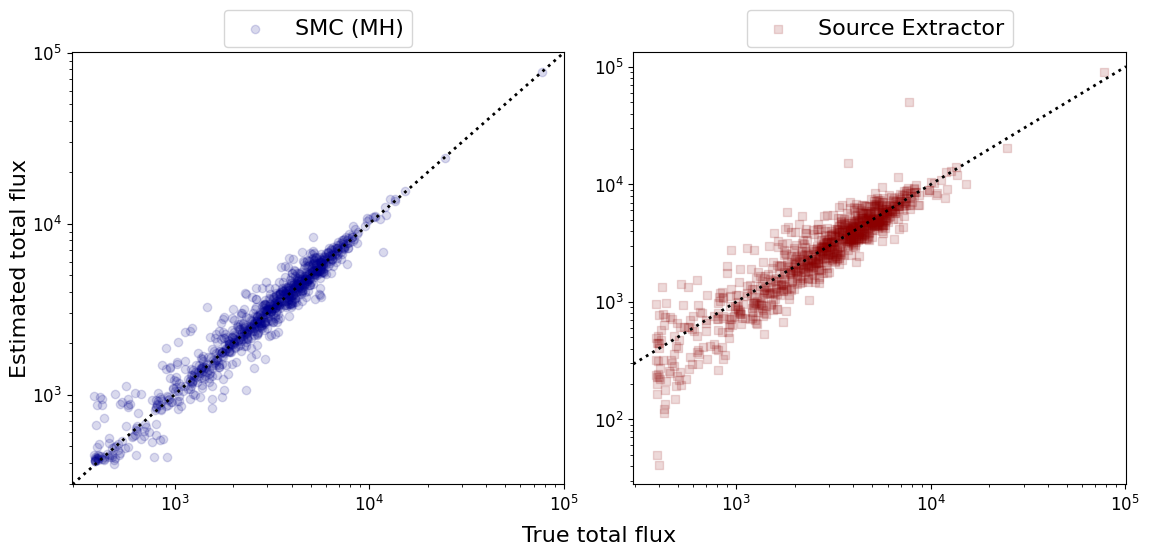

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

_ = ax[0].scatter(x = true_fluxes.sum(-1), y = smcmh_fluxes.sum(-1).median(-1).values,
                  color = smcmh_color, marker = smcmh_marker, alpha = 0.15, label = 'SMC (MH)')
_ = ax[0].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
_ = ax[0].legend(fancybox = True, loc = "upper center",
                 bbox_to_anchor = (0.5, 1.125), fontsize = fontsize)
_ = ax[0].tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax[0].set_xscale('log')
_ = ax[0].set_yscale('log')

# _ = ax[1].scatter(x = true_fluxes.sum(-1), y = smcmala_fluxes.sum(-1).median(-1).values,
#                   color = smcmala_color, marker = smcmala_marker, alpha = 0.15, label = 'SMC (MALA)')
# _ = ax[1].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
# _ = ax[1].legend(fancybox = True, loc = "upper center",
#                  bbox_to_anchor = (0.5, 1.125), fontsize = fontsize)
# _ = ax[1].tick_params(axis = "both", labelsize = 0.75 * fontsize)
# _ = ax[1].set_xscale('log')
# _ = ax[1].set_yscale('log')

_ = ax[1].scatter(x = true_fluxes.sum(-1), y = sep_fluxes.sum(-1),
                  color = sep_color, marker = sep_marker, alpha = 0.15, label = "Source Extractor")
_ = ax[1].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
_ = ax[1].legend(fancybox = True, loc = "upper center",
                 bbox_to_anchor = (0.5, 1.125), fontsize = fontsize)
_ = ax[1].tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax[1].set_xscale('log')
_ = ax[1].set_yscale('log')

_ = labels = fig.add_subplot(111, frameon = False)
_ = labels.set_xlabel('True total flux', labelpad = 30, fontsize = fontsize)
_ = labels.set_ylabel('Estimated total flux', labelpad = 30, fontsize = fontsize)
_ = labels.set_xticks([])
_ = labels.set_yticks([])

fig.tight_layout()

# fig.savefig('figures/divide_and_conquer_totalflux.png', dpi = 250, transparent = True)

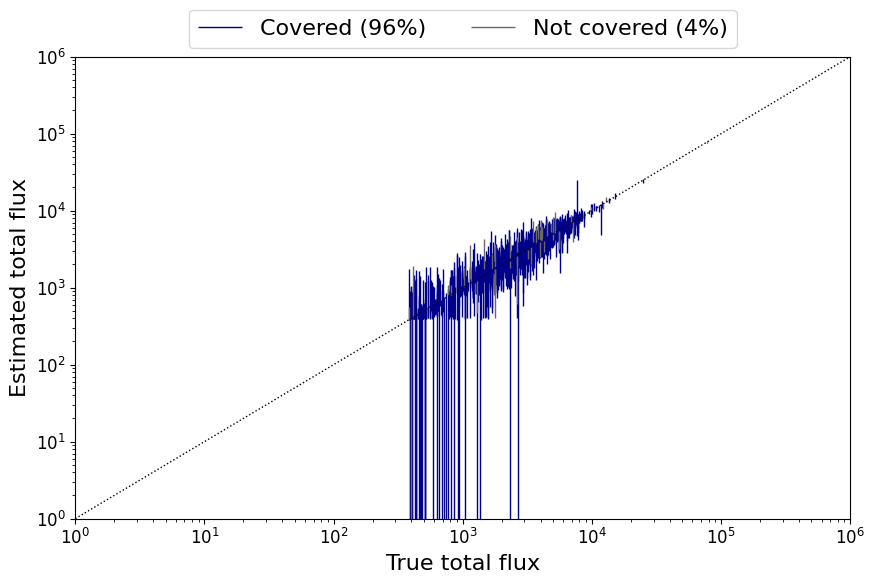

In [26]:
interval = 0.95
q05 = smcmh_fluxes.sum(-1).quantile(0.5 - interval / 2, dim = -1)
q95 = smcmh_fluxes.sum(-1).quantile(0.5 + interval / 2, dim = -1)
covered = torch.logical_and(q05 <= true_fluxes.sum(-1),
                            q95 >= true_fluxes.sum(-1))

fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.vlines(x = true_fluxes.sum(-1)[covered],
              ymin = q05[covered], ymax = q95[covered],
              color = smcmh_color, alpha = 1, linewidth = 1,
              label = f'Covered ({(covered.float().mean() * 100).round().int()}%)')
_ = ax.vlines(x = true_fluxes.sum(-1)[~covered],
              ymin = q05[~covered], ymax = q95[~covered],
              color = 'dimgray', alpha = 1, linewidth = 1,
              label = f'Not covered ({((~covered).float().mean() * 100).round().int()}%)')
_ = ax.set_xlim((1,1000000))
_ = ax.set_ylim((1,1000000))
_ = ax.axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 1)
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

_ = ax.legend(ncol = 2, fancybox = True, loc = "upper center",
              bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
_ = ax.set_xlabel('True total flux', fontsize = fontsize)
_ = ax.set_ylabel('Estimated total flux', fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)

In [27]:
# interval = 0.90
# q05 = smcmala_fluxes.sum(-1).quantile(0.5 - interval / 2, dim = -1)
# q95 = smcmala_fluxes.sum(-1).quantile(0.5 + interval / 2, dim = -1)
# covered = torch.logical_and(q05 <= true_fluxes.sum(-1),
#                             q95 >= true_fluxes.sum(-1))

# fig, ax = plt.subplots(1, 1, figsize = (10,6))

# _ = ax.vlines(x = true_fluxes.sum(-1)[covered],
#               ymin = q05[covered], ymax = q95[covered],
#               color = smcmala_color, alpha = 1, linewidth = 1,
#               label = f'Covered ({(covered.float().mean() * 100).round().int()}%)')
# _ = ax.vlines(x = true_fluxes.sum(-1)[~covered],
#               ymin = q05[~covered], ymax = q95[~covered],
#               color = 'dimgray', alpha = 1, linewidth = 1,
#               label = f'Not covered ({((~covered).float().mean() * 100).round().int()}%)')
# _ = ax.axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 1)
# _ = ax.set_xscale('log')
# _ = ax.set_yscale('log')

# _ = ax.legend(ncol = 2, fancybox = True, loc = "upper center",
#               bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
# _ = ax.set_xlabel('True total flux', fontsize = fontsize)
# _ = ax.set_ylabel('Estimated total flux', fontsize = fontsize)
# _ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)

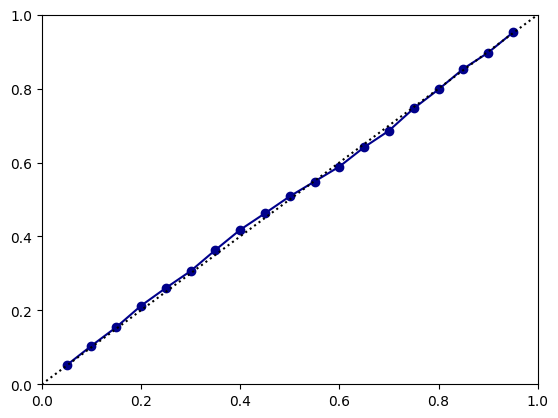

In [28]:
intervals = [c*0.05 for c in range(1,20)]
mh_coverage_rate = []
mala_coverage_rate = []

for i in intervals:
    qlow = smcmh_fluxes[true_counts>0].sum(-1).quantile(0.5 - i / 2, dim = -1)
    qhigh = smcmh_fluxes[true_counts>0].sum(-1).quantile(0.5 + i / 2, dim = -1)
    covered = torch.logical_and(qlow <= true_fluxes[true_counts>0].sum(-1),
                                qhigh >= true_fluxes[true_counts>0].sum(-1))
    
    mh_coverage_rate.append(covered.float().mean())
    
    qlow = smcmala_fluxes[true_counts>0].sum(-1).quantile(0.5 - i / 2, dim = -1)
    qhigh = smcmala_fluxes[true_counts>0].sum(-1).quantile(0.5 + i / 2, dim = -1)
    covered = torch.logical_and(qlow <= true_fluxes[true_counts>0].sum(-1),
                                qhigh >= true_fluxes[true_counts>0].sum(-1))
    
    mala_coverage_rate.append(covered.float().mean())
    

_ = plt.plot(intervals, mh_coverage_rate, color = smcmh_color)
_ = plt.scatter(intervals, mh_coverage_rate, color = smcmh_color)
# _ = plt.plot(intervals, mala_coverage_rate, color = smcmala_color)
# _ = plt.scatter(intervals, mala_coverage_rate, color = smcmala_color)
_ = plt.axline((0,0), slope = 1, linestyle = ':', color = 'black')
_ = plt.xlim((0,1))
_ = plt.ylim((0,1))

In [29]:
vsbc_mh_totalfluxes = (true_fluxes[true_counts>0].sum(-1).unsqueeze(-1) <= smcmh_fluxes[true_counts>0].sum(-1)).float().mean(-1)

ks_2samp(vsbc_mh_totalfluxes, 1 - vsbc_mh_totalfluxes)

KstestResult(statistic=0.12849162011173185, pvalue=7.404560424790213e-07, statistic_location=0.48145455, statistic_sign=-1)

In [30]:
# vsbc_mala_totalfluxes = (true_fluxes[true_counts>0].sum(-1).unsqueeze(-1) <= smcmala_fluxes[true_counts>0].sum(-1)).float().mean(-1)

# ks_2samp(vsbc_mala_totalfluxes, 1 - vsbc_mala_totalfluxes)

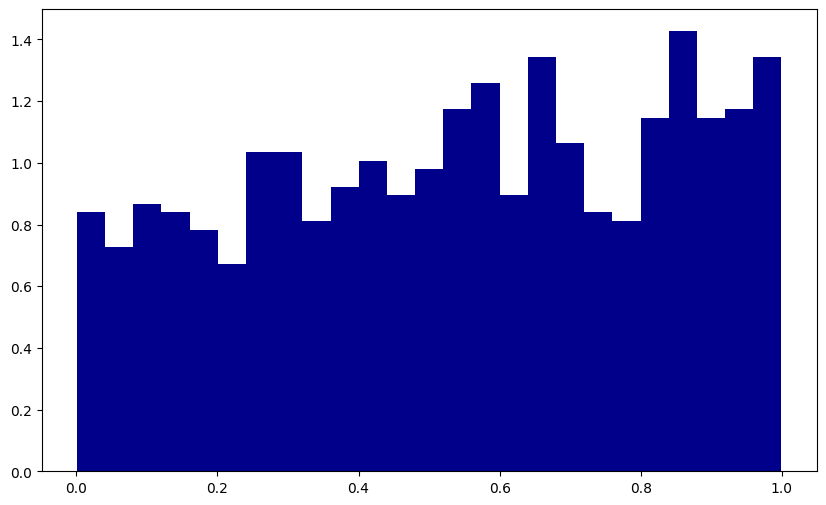

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))
_ = ax.hist(vsbc_mh_totalfluxes, bins = 25, density = True, color = smcmh_color)
# _ = ax[1].hist(vsbc_mala_totalfluxes, bins = 25, density = True, color = smcmala_color)

### Plots: Runtime and number of iterations

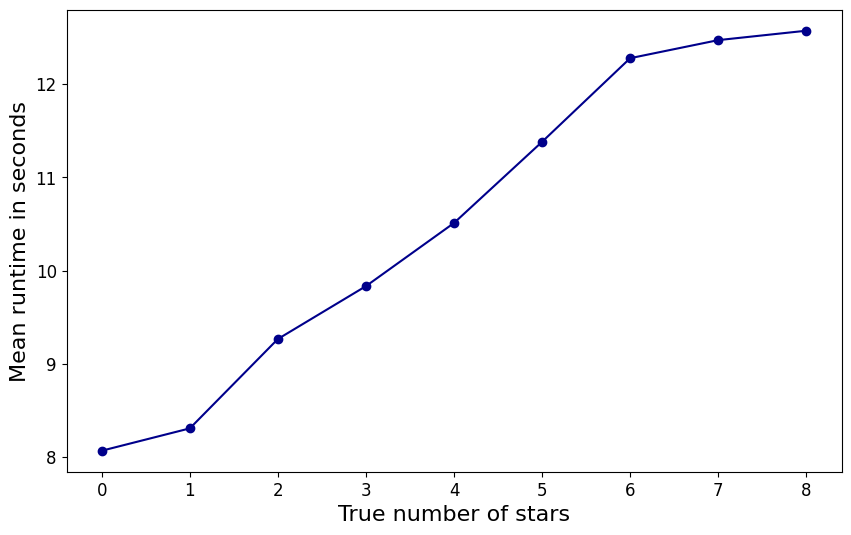

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.plot(torch.arange(num_counts), smcmh_runtime_mean, color = smcmh_color)
_ = ax.scatter(torch.arange(num_counts), smcmh_runtime_mean,
               color = smcmh_color, marker = smcmh_marker)

# _ = ax.plot(torch.arange(num_counts), smcmala_runtime_mean, color = smcmala_color)
# _ = ax.scatter(torch.arange(num_counts), smcmala_runtime_mean,
#                color = smcmala_color, marker = smcmala_marker)

_ = ax.set_xlabel('True number of stars', fontsize = fontsize)
_ = ax.set_ylabel('Mean runtime in seconds', fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)

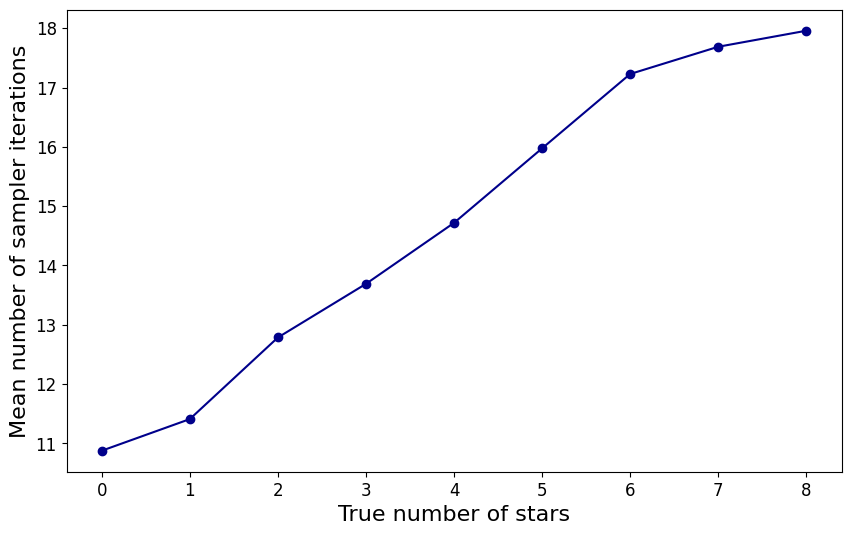

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.plot(torch.arange(num_counts), smcmh_num_iters_mean, color = smcmh_color)
_ = ax.scatter(torch.arange(num_counts), smcmh_num_iters_mean,
               color = smcmh_color, marker = smcmh_marker)

# _ = ax.plot(torch.arange(num_counts), smcmala_num_iters_mean, color = smcmala_color)
# _ = ax.scatter(torch.arange(num_counts), smcmala_num_iters_mean,
#                color = smcmala_color, marker = smcmala_marker)

_ = ax.set_xlabel('True number of stars', fontsize = fontsize)
_ = ax.set_ylabel('Mean number of sampler iterations', fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)

### Plots: Reconstructed images

In [34]:
import sys
sys.path.append('../../..')
from smc.images import ImageModel

imagemodel = ImageModel(image_height = images.shape[1],
                        image_width = images.shape[2],
                        psf_stdev = 0.93,
                        background = 200)

In [35]:
def plot_detections(image_index, smcmh_catalog_index):
    fig, ax = plt.subplots(1, 3, figsize = (15,5), layout = 'compressed')

    orig = ax[0].imshow(images[image_index], cmap = cmap)
    _ = ax[0].scatter(true_locs[image_index, :true_counts[image_index].item(), 1] - 0.5,
                    true_locs[image_index, :true_counts[image_index].item(), 0] - 0.5,
                    color = 'gold', edgecolors = 'black', marker = '*', s = 250)
    _ = ax[0].set_xticks([])
    _ = ax[0].set_yticks([])

    smcmh_psf = imagemodel.psf(smcmh_locs[image_index,smcmh_catalog_index,:].view(1,1,1,-1,2))
    smcmh_rate = (smcmh_psf * smcmh_fluxes[image_index,smcmh_catalog_index,:].view(1,1,1,1,1,-1)).sum(-1) + imagemodel.background
    smcmh_reconstruction = smcmh_rate.squeeze([0,1]).permute((2,0,1)).squeeze()
    smcmh_recon = ax[1].imshow(smcmh_reconstruction, cmap = cmap)
    _ = ax[1].scatter(smcmh_locs[image_index, smcmh_catalog_index, :smcmh_counts[image_index, smcmh_catalog_index].int().item(), 1] - 0.5,
                      smcmh_locs[image_index, smcmh_catalog_index, :smcmh_counts[image_index, smcmh_catalog_index].int().item(), 0] - 0.5,
                      color = 'dodgerblue', edgecolors = 'black', marker = '*', s = 250)
    _ = ax[1].set_xticks([])
    _ = ax[1].set_yticks([])

    sep_psf = imagemodel.psf(sep_locs[image_index, :].view(1,1,1,-1,2))
    sep_rate = (sep_psf * sep_fluxes[image_index,:].view(1,1,1,1,1,-1)).sum(-1) + imagemodel.background
    sep_reconstruction = sep_rate.squeeze([0,1]).permute((2,0,1)).squeeze()
    sep_recon = ax[2].imshow(sep_reconstruction, cmap = cmap)
    _ = ax[2].scatter(sep_locs[image_index, :sep_counts[image_index].int().item(), 1] - 0.5,
                      sep_locs[image_index, :sep_counts[image_index].int().item(), 0] - 0.5,
                      color = 'red', edgecolors = 'black', marker = '*', s = 250)
    _ = ax[2].set_xticks([])
    _ = ax[2].set_yticks([])
    
    return fig

In [36]:
np.random.seed(1)

image_indexes = torch.zeros(num_counts, 1)

for c in range(num_counts):
    image_indexes[c] = torch.tensor(np.random.choice((true_counts == c).nonzero().squeeze(),
                                                     size = 1, replace = False))

image_indexes = image_indexes.int()

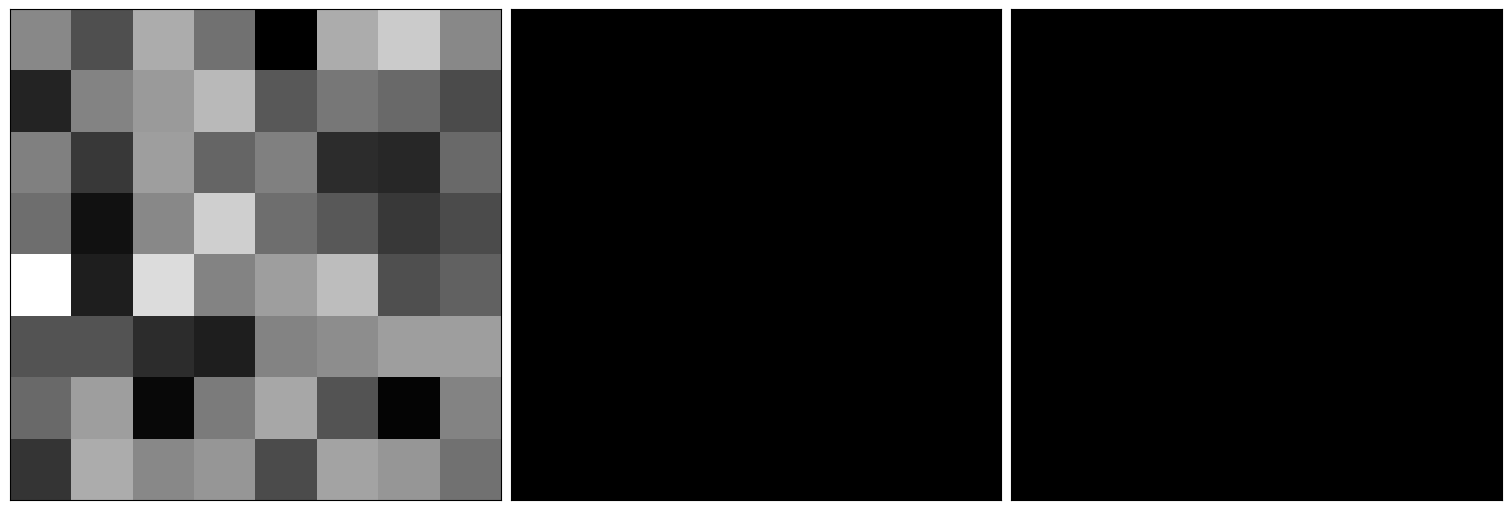

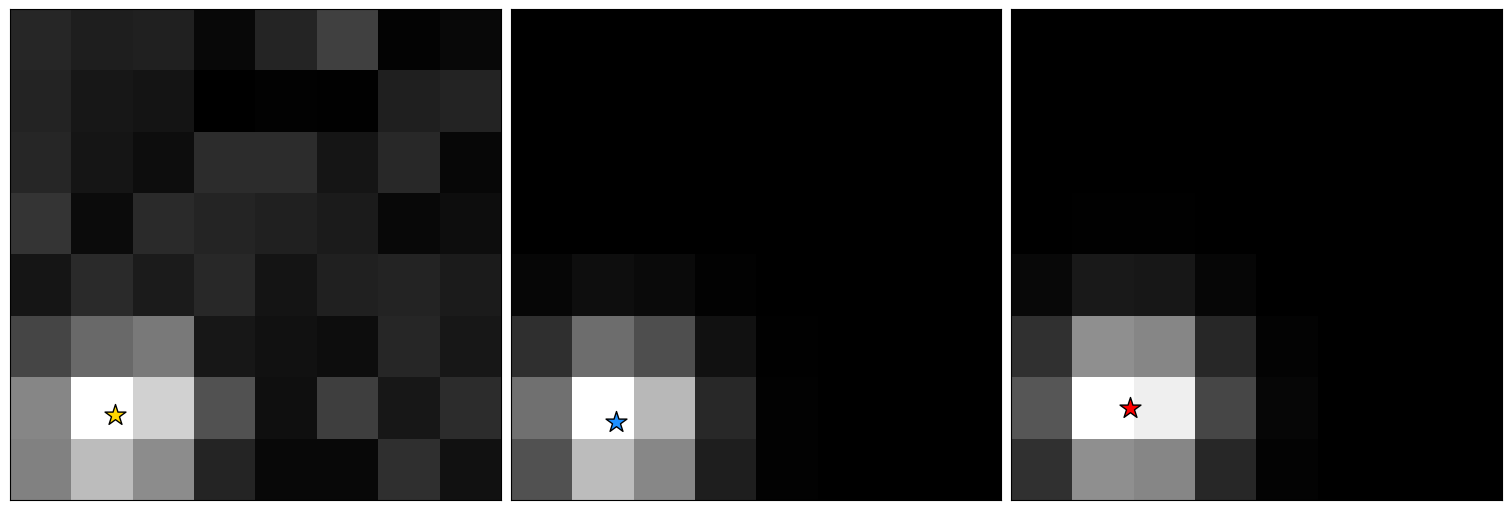

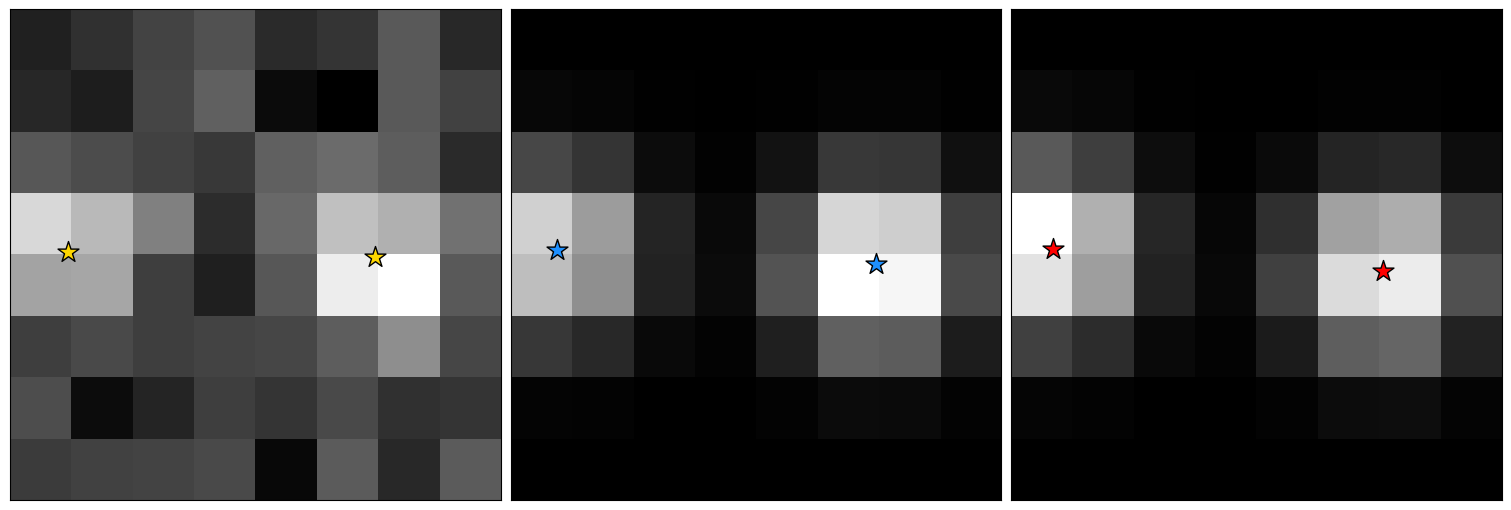

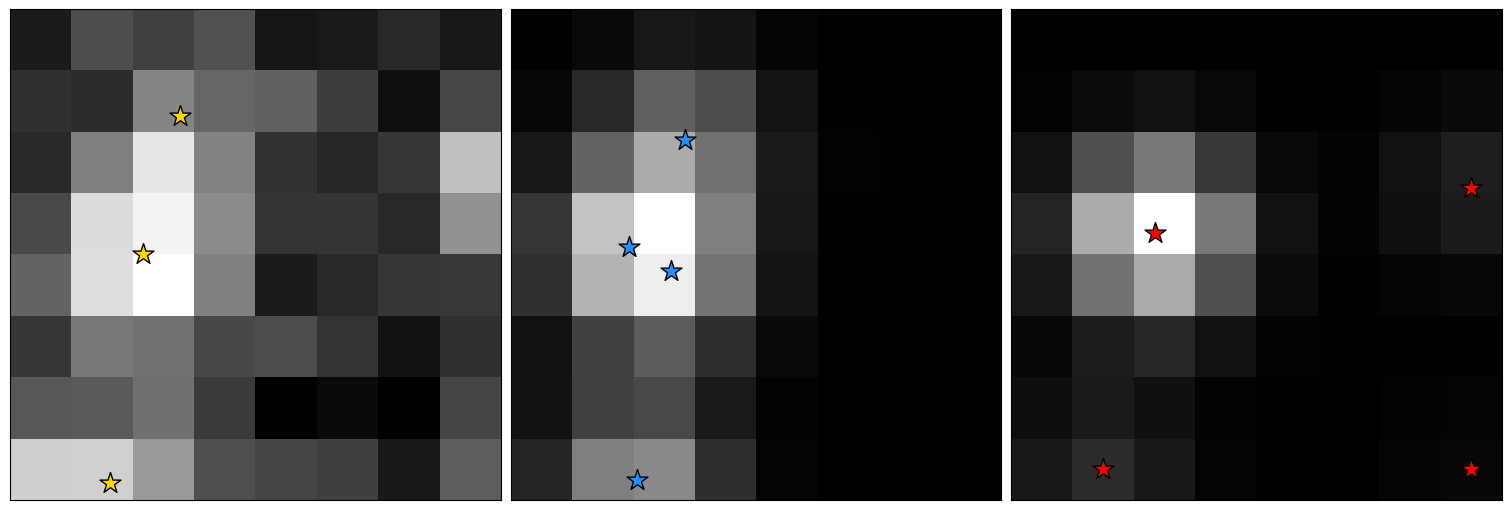

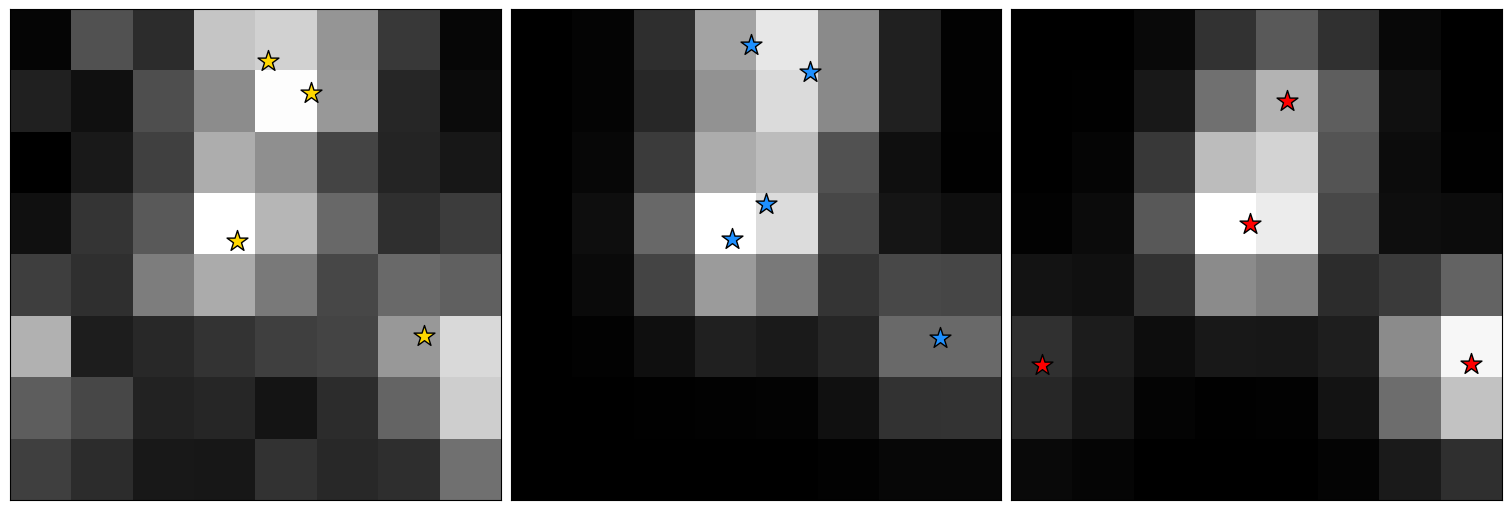

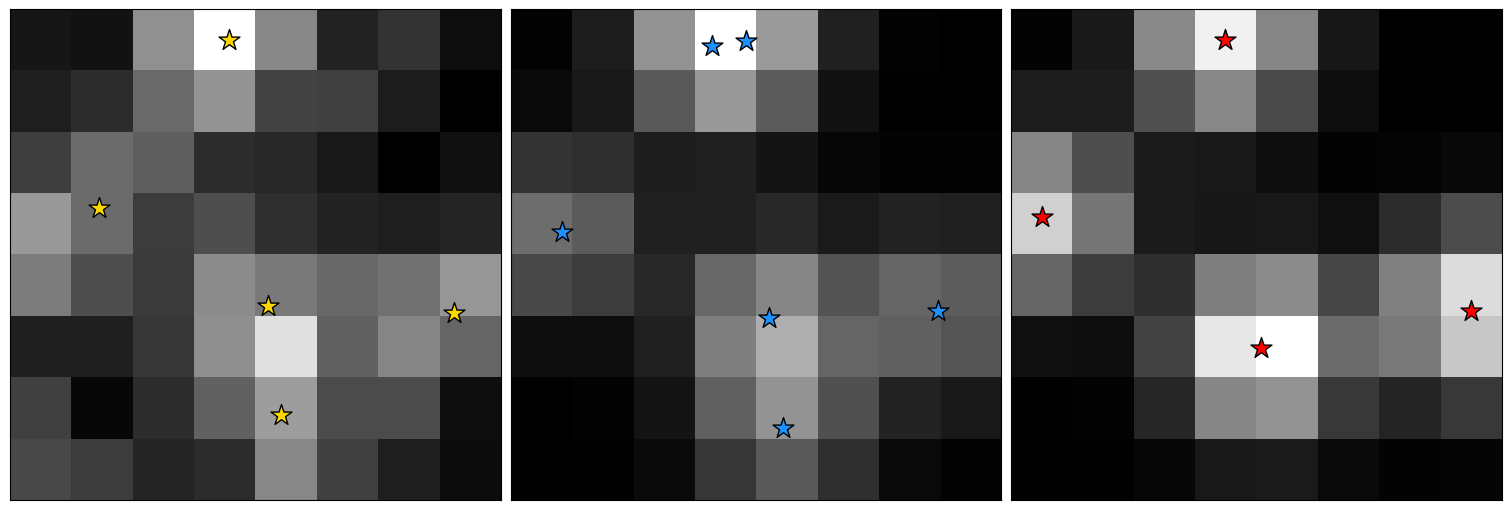

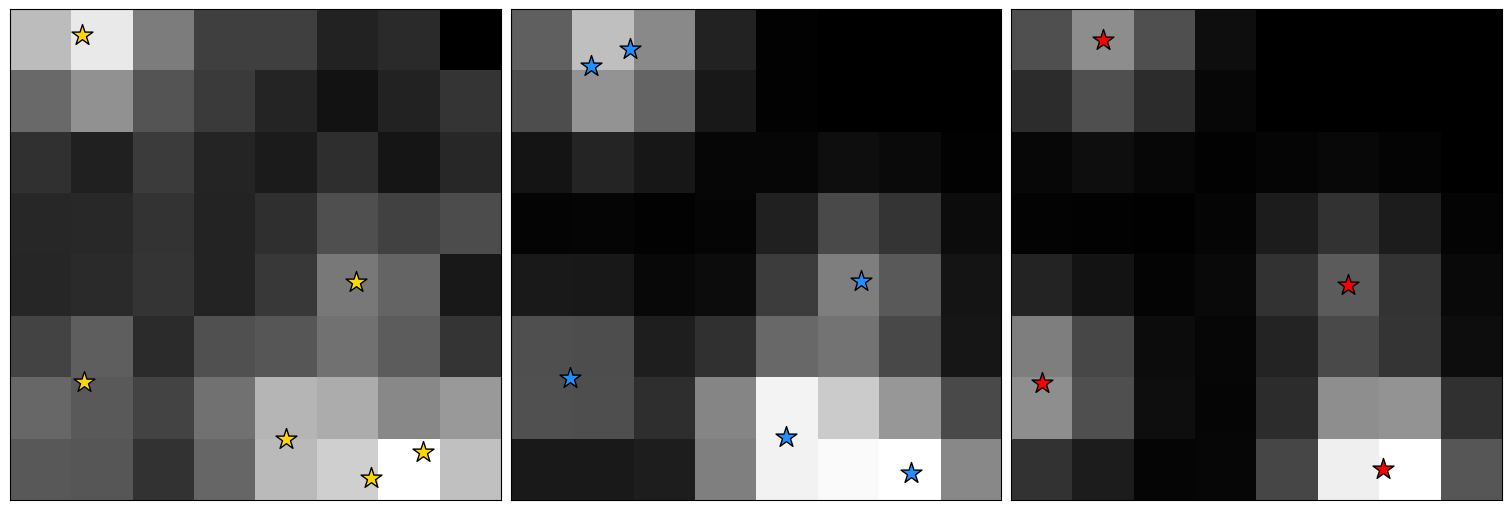

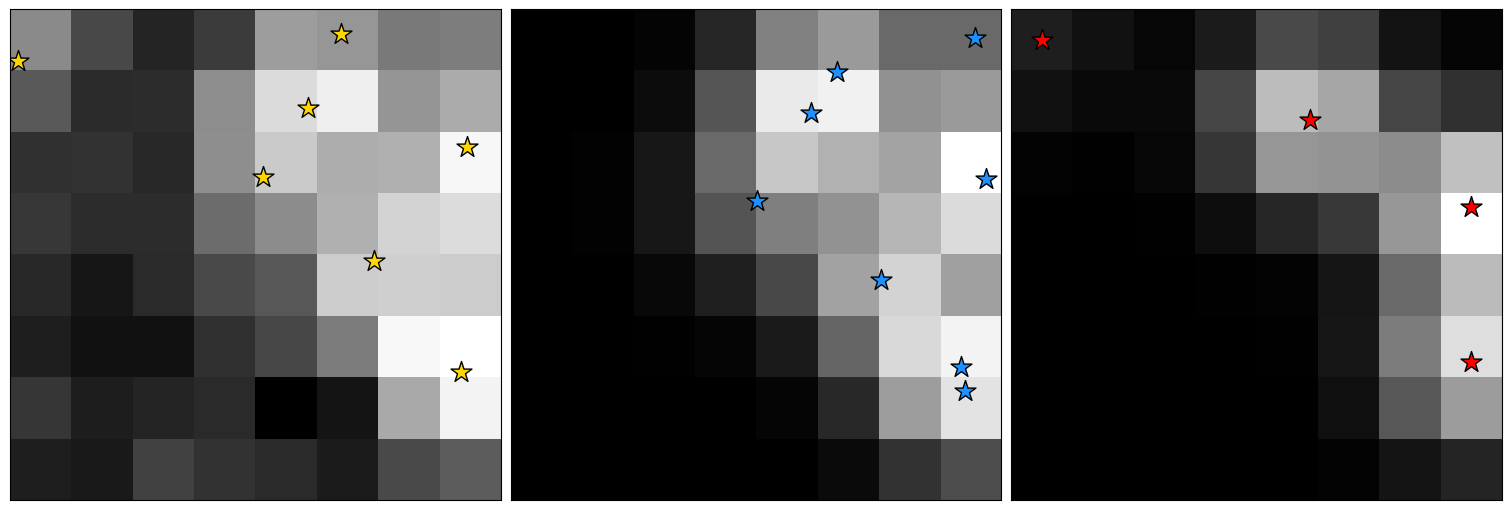

In [37]:
for c in range(num_counts):
    unique, num = smcmh_fluxes[image_indexes[c,0]].unique(dim = 0, return_counts = True)
    cat1 = unique[num.topk(k = 1).indices]
    cat_index = (smcmh_fluxes[image_indexes[c,0]] == cat1).all(dim = 1).nonzero()[0].item()
    plot_detections(image_indexes[c,0], cat_index)

plt.close()